This code is meant to run mianalyzer headless. Mianalyzer is a code that can run a variety of neural network architrecture and backbones, without the user having ot define them himeself. It normally runs as a GUI application. However, when run on a remote server, the GUI version is much too slow,  The mianalyzer author (koerber) kindly provided a python script to run the training sequence  headless, after loading a "pickled"dl object from a pkl file. 

The script has been extended by Aryeh Weiss in the following ways:

Inputs:
    1. Directory that holds the pkl file
    2. Directory where the model will be saved
    3. The name of the saved pkl file (the pkl extensionis assumed)
    4. The directory containing the training data. The Segmentation_labels subdiretory must also be present.
    5. The prediction folder containing images on which the trained model will be tested. 
    6. model backbone (default is densenet201)
    7. number of epochs (default defined in the pkl file)

 Outputs:
    1. The dl object that will be used to train the model
    2. A subdirectory that will hold the segmented images.

This Jupyter script is based on code provided by koerber (author of mianalyzer)

Modifed by Aryeh Weiss

Last modified: 18 June 2023

This version of the script usees tkinter to prompt for teh various directories and files that are needed.
The defaults are the same, and cliking ok will select default values.
When run on a remote GPU server, this version will be slower because it opens X windows on the local machine,
pver the network.

TODO: 1. Add a drop down mwnu for all of the possible backbones.
      2. Change default backone to be that of teh pkl file (currenlty it is densenet201)

In [1]:
import pickle
import os 
import cv2
import glob
import matplotlib.pyplot as plt

from pprint import pprint

# select one of the multiple GPU cards on the server.
os.environ["CUDA_VISIBLE_DEVICES"]="0" # set GPU if multiple present


In [2]:
'''
This code is developed and run on at least two machines
Here we setup the default paths for each machine.
Eventually we must find a more general way to do this.
'''

host = os.getenv('HOSTNAME')
if host==None:      # pop os dees not have HOSTNAME defined by default.
    host = "pop"
print(host)

if "dsigpu" in host:
    pklDir = '/home/dsi/aryeh/data/mia/pkl/'
    modelDir = '/home/dsi/aryeh/data/mia/trained_models/'
    modelname = "unetDensnet201_2023-01-24_08-17-37"
    trainingdata = '/home/dsi/aryeh/data/plants/unCropped/resized/'
    predictionFolder = '/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/'
elif "pop" in host:
    pklDir = '/media/amw/TOSHIBA EXT/alerding/models/pkl/'
    modelDir = '/media/amw/TOSHIBA EXT/alerding/models/gpuModels/'
    modelname = "unetDensnet201_2023-01-24_08-17-37"
    trainingdata =  '/media/amw/TOSHIBA EXT/alerding/annotated/notCroppedLabels2/resized/'
    predictionFolder = '/media/amw/TOSHIBA EXT/alerding/Harvest 8 Orange 5,7 Oct 17.r/vertical/'
else:
    pklDir = None
    modelDir = None 
    modelname = "unetDensnet201_2023-01-24_08-17-37"
    trainingdata = None
    predictionFolder = None

dsigpu04


In [3]:
os.environ['DISPLAY']='localhost:10.0'

import tkinter as tk
from tkinter import filedialog as fd

root = tk.Tk()
root.withdraw()

pklDir = fd.askdirectory(initialdir=pklDir) + os.sep
modelDir = fd.askdirectory(initialdir=modelDir) + os.sep
trainingdata = fd.askdirectory(initialdir=trainingdata) + os.sep
predictionFolder = fd.askdirectory(initialdir=predictionFolder) + os.sep

modelFilePath = fd.askopenfilename(
        title='Open a pkl file',
        initialdir=pklDir)

filename = os.path.basename(modelFilePath)
modelname = os.path.splitext(filename)[0]

print("model: ", modelname)

# it would be a good idea to collect all of the legitimate backbones and display them in a drop down menu.
BackBone = input("input backbone or enter for default\n") or None

strEpochs = input("input number of epochs or enter to use the predefined value in a pkl file\n") or '0'
epochs = int(strEpochs)

validationdata = None

loadweights = None



model:  UNet_seresnext101_ep100


In [4]:
'''
This is from the version that reads the dl object from a pkl file.
'''

print('load settings')
#filehandler = open(modelname + '.pkl', 'rb')
filehandler = open(pklDir + modelname + '.pkl', 'rb')

dl = pickle.load(filehandler)
print(dl.epochs)
if epochs != 0:
    dl.epochs = epochs
if BackBone != None:
    dl.Mode.backbone = BackBone
pprint(vars(dl.Mode))


load settings


2023-06-19 07:30:57.376324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


100
{'architecture': 'UNet',
 'backbone': 'seresnext101',
 'loss': <dl.loss.segmentation_losses.SegmentationLosses object at 0x7f567d8295d0>,
 'metric': <dl.metric.segmentation_metrics.SegmentationMetrics object at 0x7f567d8293d0>,
 'parent': <dl.DeepLearning.DeepLearning object at 0x7f56c91e41d0>,
 'preprocessingfnc': None,
 'pretrained': True,
 'type': <dlMode.Segmentation: 2>}


In [5]:
'''
Run this cell if you want to save the dl object as a pkl file
'''

pklFileHandler = open(pklDir+dl.Mode.architecture+'_'+dl.Mode.backbone+'_ep'+str(dl.epochs) + '.pkl','wb')
#import sys
#print(sys.getrecursionlimit())
#sys.setrecursionlimit(4*sys.getrecursionlimit())
#print(sys.getrecursionlimit())

hed = dl.hed
dl.hed = None
model = dl.Model
dl.Model = None
pickle.dump(dl, pklFileHandler)
dl.hed = hed
dl.Model = model



In [6]:
# pod, stem, background, and unlabeled (for deleaved soybean plants)
numClasses =4

print('init model')
dl.initModel(numClasses)

dl.Model = dl.Mode.getModel(numClasses, 3)

print('load model')
if loadweights is not None:
    dl.Model.load_weights(loadweights)

print(dl.initialized)

init model


2023-06-19 07:31:26.258974: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-19 07:31:26.267032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-19 07:31:27.721020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2023-06-19 07:31:27.721075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-19 07:31:27.733181: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-19 07:31:27.733243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.s

load model
True


In [7]:
'''
Here we  do the training
'''
        
if dl.initialized:
    print('start training')
    dl.initData_StartTraining(trainingdata, validationdata)
    print('training finished')
else:
    print('could not initialize model')
            
print('saving weights')
modelname=dl.Mode.architecture+'_'+dl.Mode.backbone
dl.Model.save_weights(modelDir+modelname+'_ep'+str(dl.epochs) + '.h5')
print('saving training data')
dl.saveTrainingRecord(modelDir+modelname+'_ep'+str(dl.epochs) +'.csv')
#   print('saving model')
#   dl.Model.save(modelDir+'full')
    



start training


2023-06-19 07:32:21.368287: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-19 07:32:21.369054: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199975000 Hz


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-06-19 07:33:54.242623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-19 07:33:56.518612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


145/145 [==============================] - 182s 586ms/step - loss: 0.0078 - pixel_accuracy: 195099.9141 - val_loss: 0.0883 - val_pixel_accuracy: 8972.7861
Epoch 2/100
145/145 [==============================] - 88s 605ms/step - loss: 0.0056 - pixel_accuracy: 199067.7741 - val_loss: 0.0120 - val_pixel_accuracy: 142447.7500
Epoch 3/100
145/145 [==============================] - 94s 638ms/step - loss: 0.0052 - pixel_accuracy: 237415.7376 - val_loss: 0.0250 - val_pixel_accuracy: 180835.6094
Epoch 4/100
145/145 [==============================] - 69s 468ms/step - loss: 0.0054 - pixel_accuracy: 239091.3829 - val_loss: 0.0048 - val_pixel_accuracy: 243337.2812
Epoch 5/100
145/145 [==============================] - 63s 427ms/step - loss: 0.0050 - pixel_accuracy: 234557.8029 - val_loss: 0.0039 - val_pixel_accuracy: 253658.8281
Epoch 6/100
145/145 [==============================] - 62s 428ms/step - loss: 0.0048 - pixel_accuracy: 235444.9059 - val_loss: 0.0079 - val_pixel_accuracy: 244677.6719
Epoch

31
/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.3.jpg


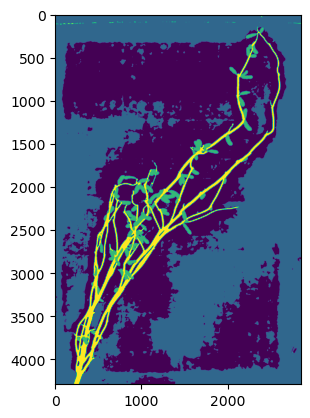

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.305.2.jpg


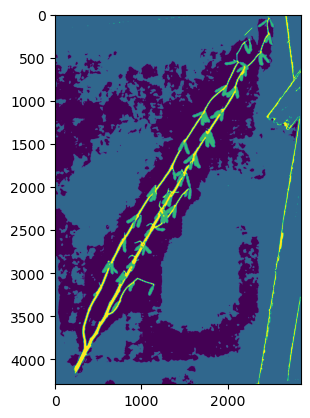

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.4.b.jpg


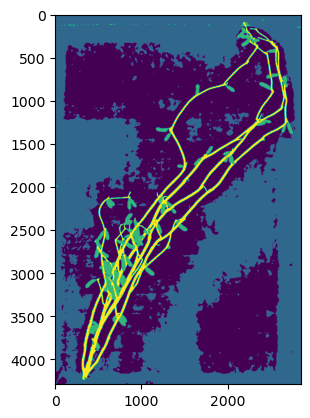

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.308.4.jpg


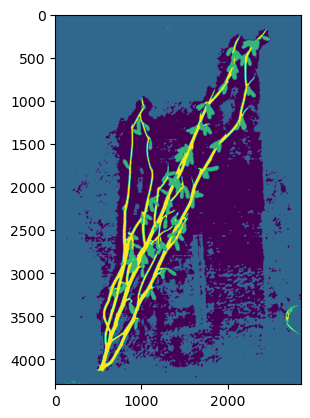

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.b.jpg


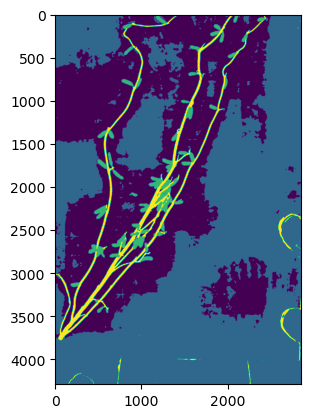

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.308.1.c.jpg


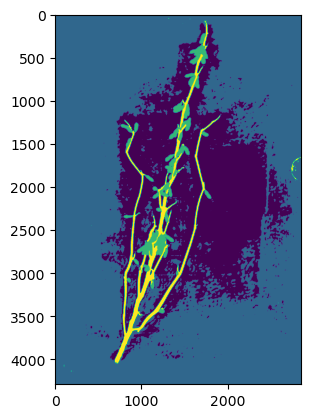

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.d.jpg


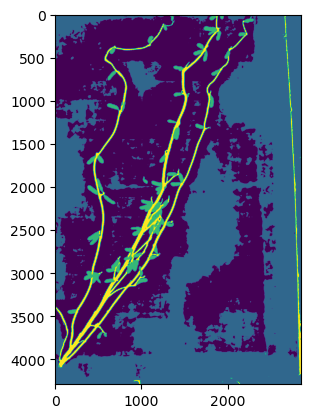

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.305.1.jpg


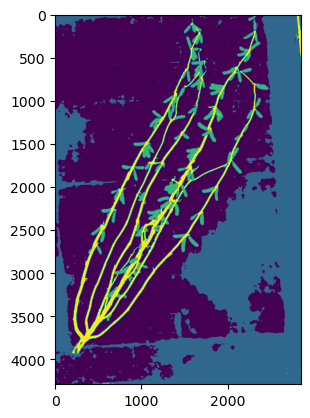

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.3.b.jpg


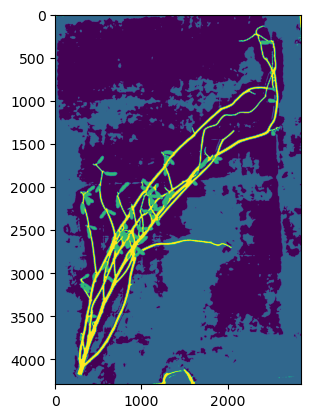

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.305.3.jpg


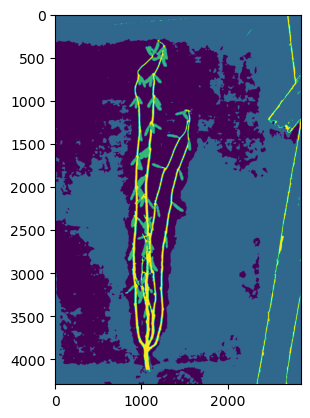

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.3.c.jpg


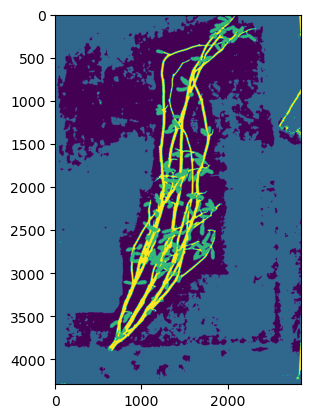

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.309.4.jpg


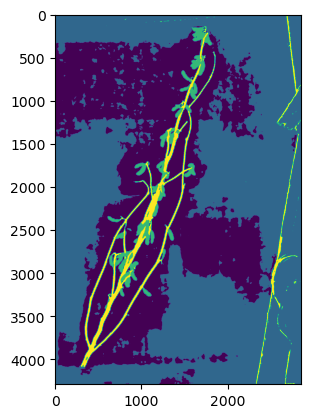

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.3.d.jpg


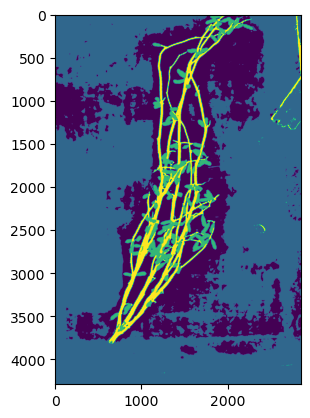

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.jpg


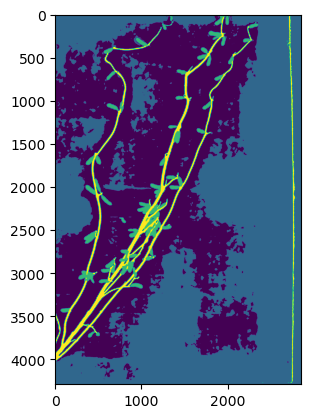

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.305.4.jpg


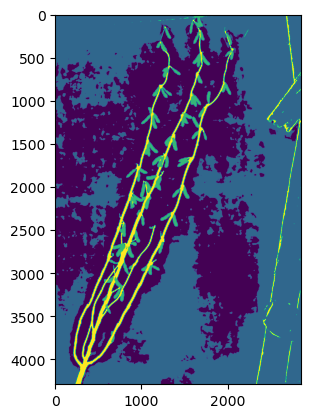

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.308.2.jpg


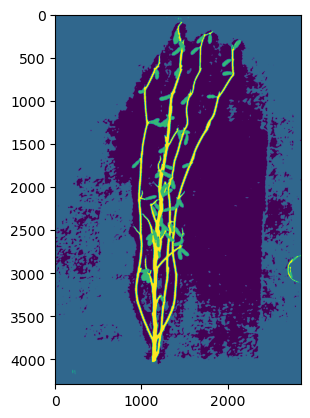

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.309.3.jpg


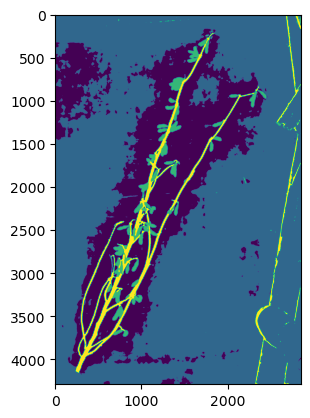

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.308.1.b.jpg


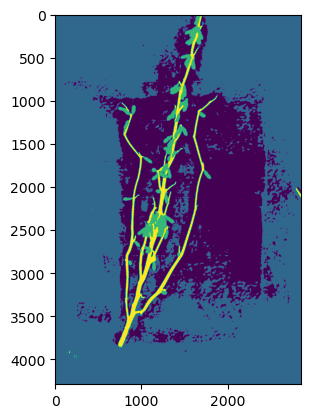

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.3.e-TRUE.jpg


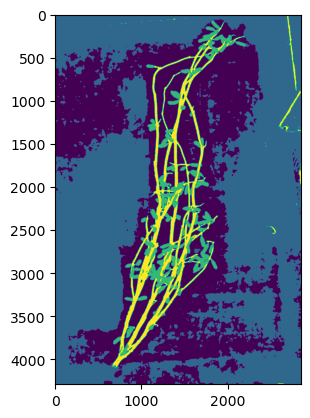

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.1.jpg


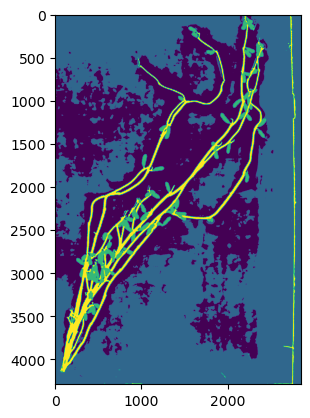

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.309.1.jpg


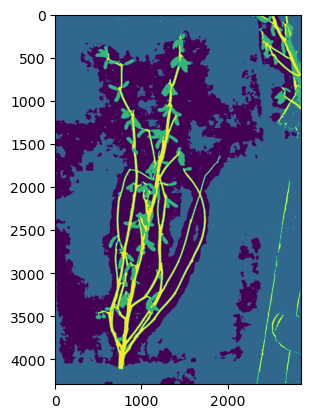

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.309.2.jpg


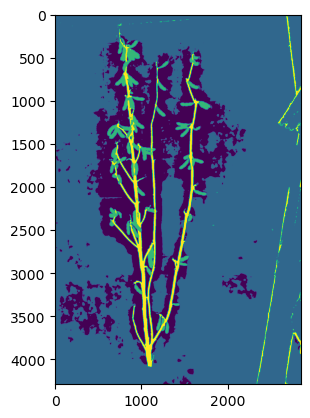

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.e.jpg


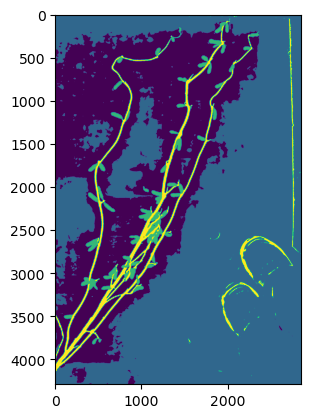

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.g.jpg


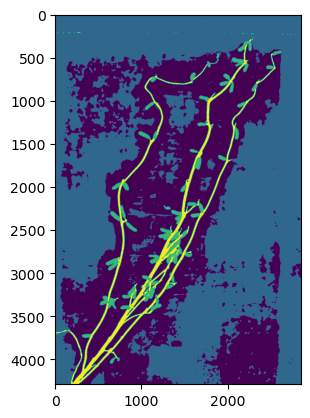

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.c.jpg


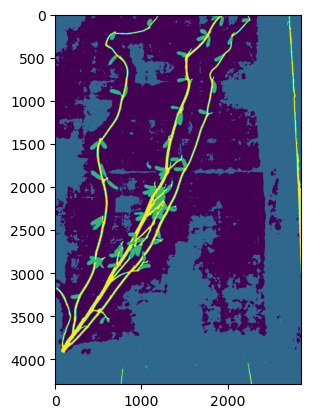

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.308.3.jpg


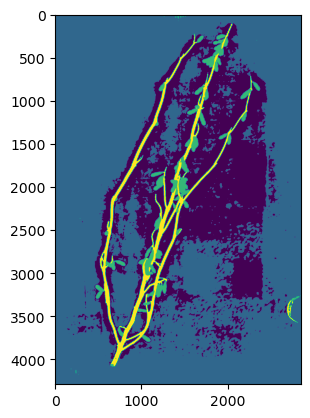

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.308.1.jpg


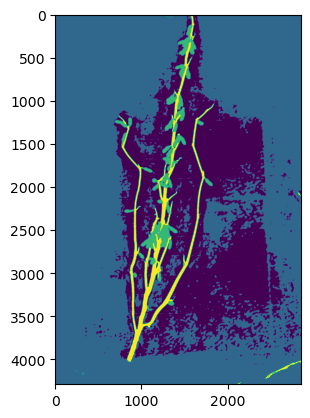

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.h.jpg


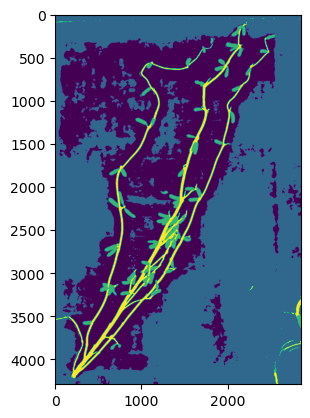

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.f.jpg


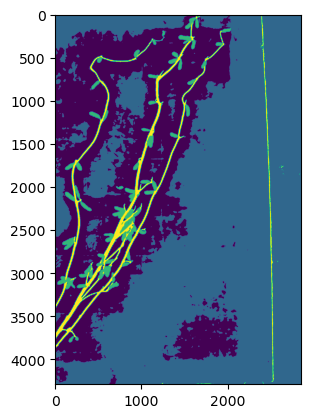

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.4.jpg


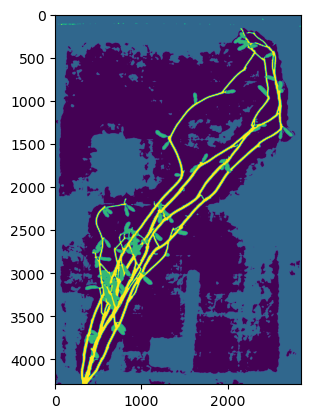

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.305.4.b.jpg


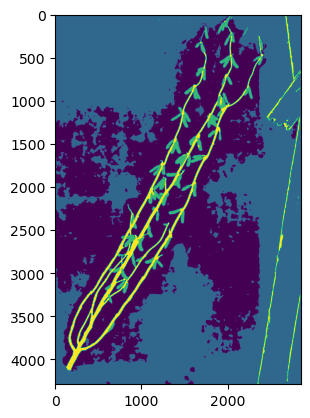

In [8]:
# This cell does a prediction on a directory of jpg images (could be any type, but that is what I have).
# predictionFolder contains the images which ill be predicted, and a subdirectory with the modelname will be created
# to hold the predicted segmentation.

predictionFolder = fd.askdirectory(initialdir=predictionFolder) + os.sep
outputPath = predictionFolder + modelname+'_ep'+str(dl.epochs)+'/'
try:
    os.mkdir(outputPath)
except FileExistsError:
    pass
files = glob.glob(predictionFolder + '*.jpg')
print(len(files))

# If we do not want to process the entire folder, we can limit the number of processed image to count. 
# If the entire folder is processed, then it wold be agood idea to comment out the image display 
count = 0
for i in files:
    print(i)
    img = cv2.imread(i)
    prediction = dl.Mode.PredictImage(img)
    plt.figure(count)
    plt.imshow(prediction)
    plt.show()
    cv2.imwrite(outputPath+'segmented_'+os.path.basename(i).replace('jpg', 'png'), prediction)
    count += 1
#    if count > 10:
#       break
    

